In [10]:
from graphs.diagrams import *
import pandas as pd

In [11]:
df = pd.read_csv(r'laptop_price_dataset.csv')

In [12]:
def process_dataset(raw_df, document_text):
    import pandas as pd
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    import re
    import pint
    from collections import Counter

    import nltk
    import ssl

    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    nltk.download('stopwords')

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    ureg = pint.UnitRegistry()


    def detect_data_type(column_values):
        unique_values = column_values.dropna().unique()
        num_unique = len(unique_values)
        if column_values.dropna().apply(lambda x: str(x).replace('.', '', 1).isdigit()).all():
            if num_unique <= 10:
                return "Numerical Discrete"
            else:
                return "Numerical Continuous"
        elif column_values.dtype == 'object':
            if num_unique <= 10:
                return "Nominal Categorical"
            else:
                return "Ordered Categorical"
        return "Unknown"

    # Detect unit dynamically
    def detect_unit(column_values, col_name):
        unit_candidates = []
        for value in column_values.dropna().astype(str):
            try:
                quantity = ureg(value)
                unit = str(quantity.units)
                if unit and unit != 'dimensionless':
                    unit_candidates.append(unit)
            except:
                pass

        if not unit_candidates:
            matches = re.findall(r"\(([a-zA-Z%°]+)\)", col_name)
            unit_candidates.extend(matches)

        most_common_units = [unit for unit, count in Counter(unit_candidates).most_common(1)]
        return most_common_units[0] if most_common_units else "none"

    def preprocess_text(text):
        tokens = word_tokenize(str(text).lower())
        tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalnum() and t not in stop_words]
        return tokens

    def assign_domain(column_name, data_type, unit, domain_keywords):
        col_keywords = preprocess_text(column_name)
        type_keywords = preprocess_text(data_type)
        unit_keywords = preprocess_text(unit)
        all_keywords = col_keywords + type_keywords + unit_keywords

        best_domain = None
        best_subdomain = None
        max_score = 0

        for domain, keywords in domain_keywords.items():
            overlap = set(all_keywords) & set(keywords)
            score = len(overlap)
            if overlap & set(col_keywords):
                score += 3
            if overlap & set(unit_keywords):
                score += 2
            if overlap & set(type_keywords):
                score += 1


            if score > max_score:
                max_score = score
                best_domain = domain
                best_subdomain = ', '.join(overlap) if overlap else 'General'

        if not best_domain:
            best_domain = 'Unknown'
            best_subdomain = 'Unknown'

        return best_domain, best_subdomain

    def parse_domains(document_text):
        domain_keywords = {}
        current_domain = None
        for line in document_text.split('\n'):
            line = line.strip()
            if line and '–' in line:
                domain, keywords = line.split('–', 1)
                current_domain = domain.strip()
                domain_keywords[current_domain] = preprocess_text(keywords)
            elif line and current_domain and '–' not in line:
                domain_keywords[current_domain].extend(preprocess_text(line))
        return domain_keywords

    metadata = {
        'column_name': raw_df.columns.tolist(),
        'data_type': [detect_data_type(raw_df[col]) for col in raw_df.columns],
        'unit': [detect_unit(raw_df[col], col) if "Numerical" in detect_data_type(raw_df[col]) else "none" for col in
                 raw_df.columns]
    }
    df = pd.DataFrame(metadata)

    domain_keywords = parse_domains(document_text)
    df[['Major_Domain', 'Sub_Domain']] = df.apply(
        lambda row: assign_domain(row['column_name'], row['data_type'], row['unit'], domain_keywords),
        axis=1, result_type='expand'
    )
    return df


In [13]:
document_text = """
Finance & Banking – Stock market, insurance, loans, dollar, price
Technology (IT & Software) – AI/ML, cybersecurity, GHz, GB, inch, hours, cpu, ram, screen, battery
Manufacturing & Production – Quality control, kg, weight
"""

mapping_df = process_dataset(df, document_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crepantherx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
diagram_mapping = {
    'Ordered Categorical': plot_bar,
    'Nominal Categorical': plot_pie,
    'Numerical Continuous' : plot_hist,
    'Numerical Discrete': plot_kde,
}

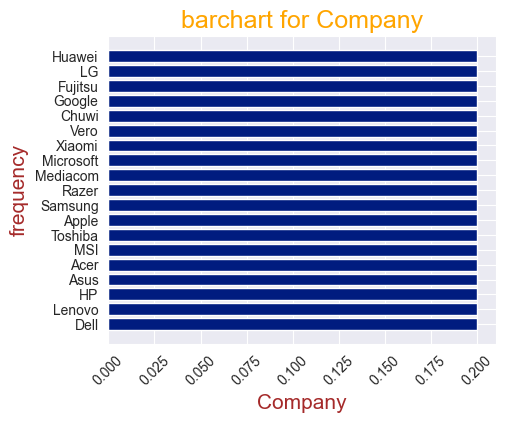

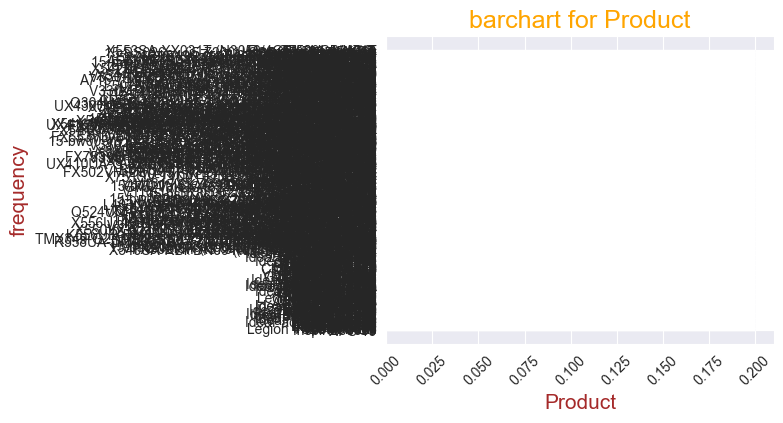

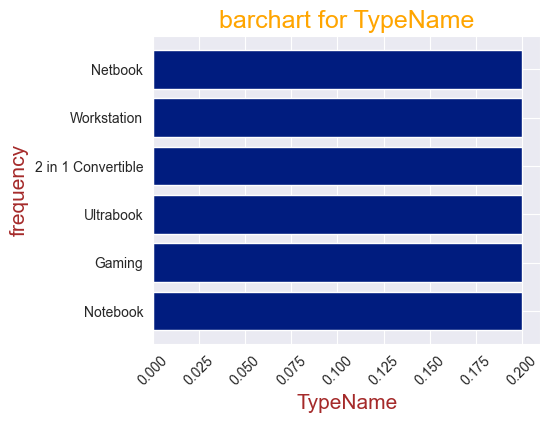

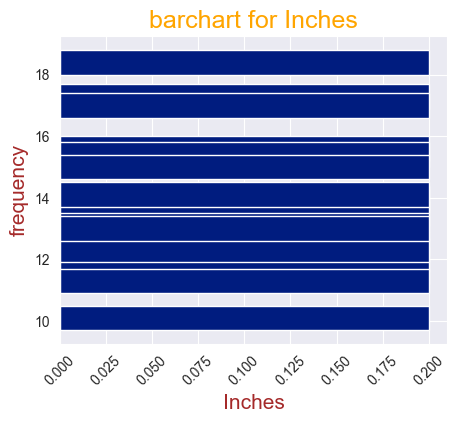

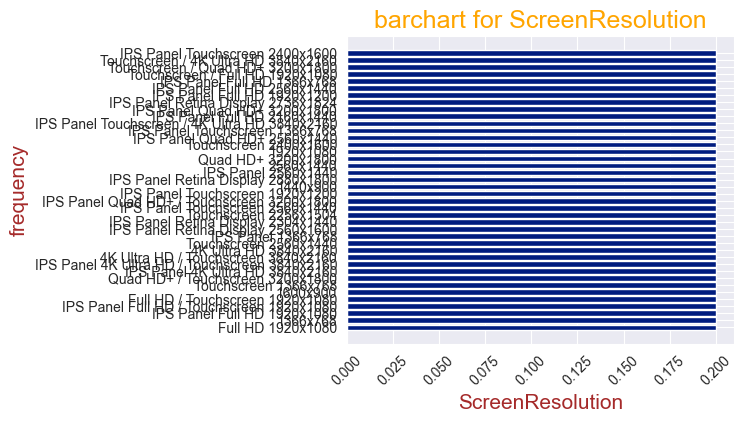

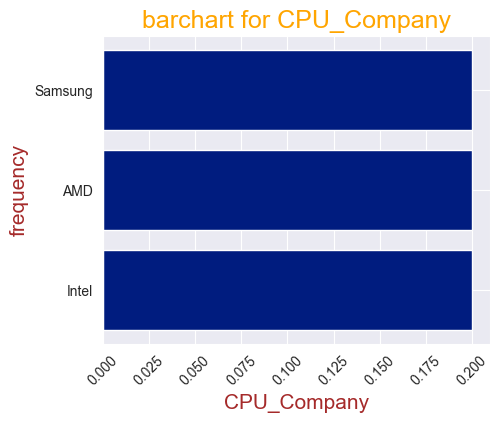

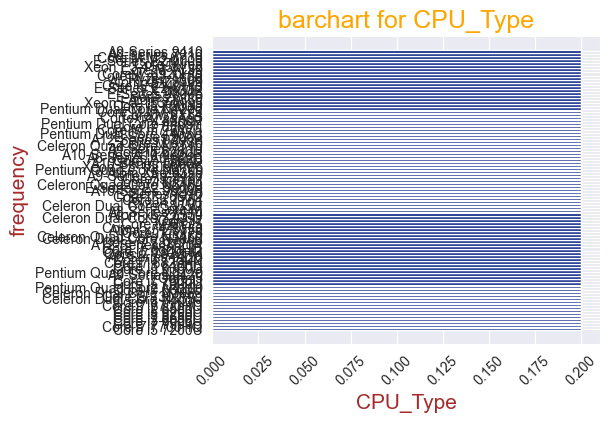

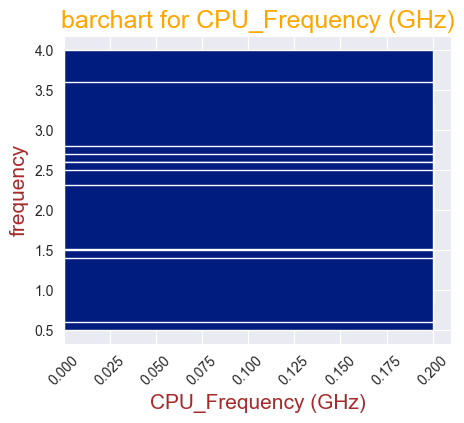

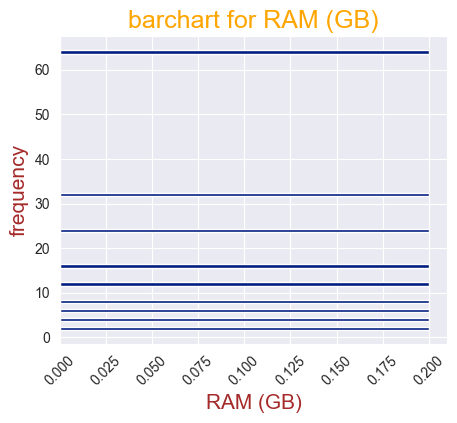

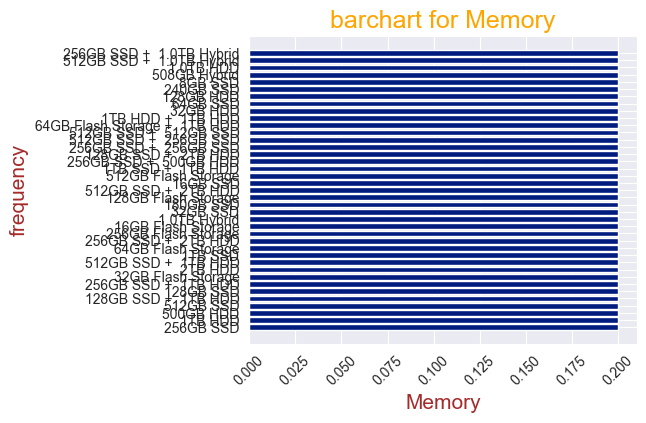

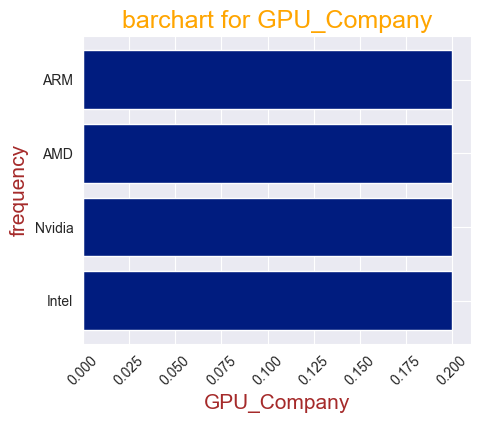

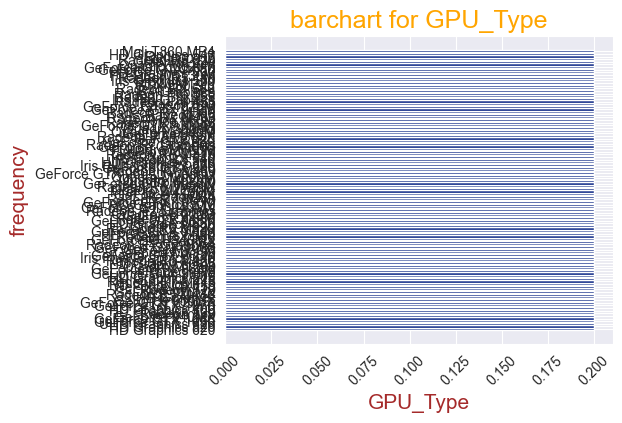

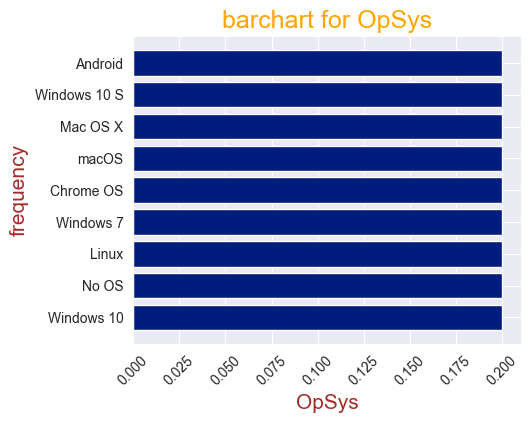

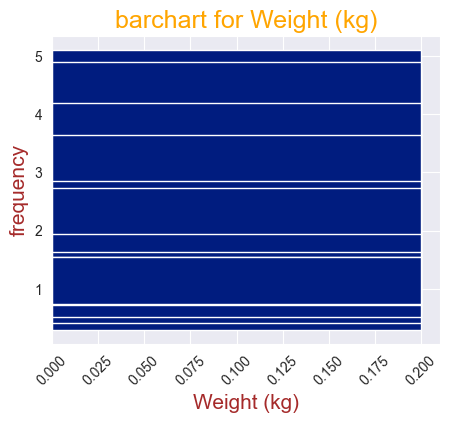

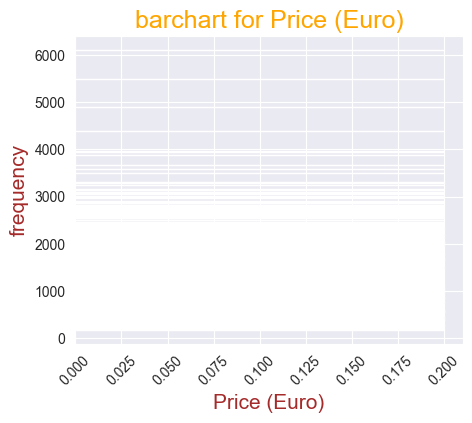

In [16]:
for col_name in df.columns:
    col_type = mapping_df[mapping_df['column_name'] == 'Company']['data_type'].to_string(index=False)
    diagram_mapping[col_type](df, col_name)